In [ ]:
# Thanks for explanation and code, 
# https://liverungrow.medium.com/sift-bag-of-features-svm-for-classification-b5f775d8e55f
# https://www.programmersought.com/article/12294296973/
# SIFT (Bag of features) + SVM for classification + K-means clustering
# 2021. 5. 23

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd
import torch
from sklearn.metrics.pairwise import linear_kernel
import collections
from sklearn import svm

N = 200
DATA_PATH = '../../../Documents/shopee-product-matching/'
#DATA_PATH = 'shopee-product-matching/'
train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
train = train.head(N)
text_data = train['title']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [2]:
sorted_train = train.sort_values(by='label_group')
sorted_train = sorted_train.reset_index(drop=True) # initialize indexing

sorted_train.head()

,posting_id,image,image_phash,title,label_group,target
0,train_961019399,../../../Documents/shopee-product-matching/tra...,b1ccce33b0ccb332,Masker Scuba Korea Anti Polusi & Debu Bahan Scuba,98592019,[train_961019399]
1,train_404207615,../../../Documents/shopee-product-matching/tra...,ae2ed1d1d1d12ad8,Natur Hair Tonic Ginseng dan Aloe Vera 90ml,122550860,[train_404207615]
2,train_149323111,../../../Documents/shopee-product-matching/tra...,ec85d23ee429c396,Bantal Olus Pillow Bayi - Bantal Anti Peyang u...,151221854,[train_149323111]
3,train_4027585169,../../../Documents/shopee-product-matching/tra...,b38c87970c387a2f,LONG OVERALL VENDETA ROK PANJANG JEANS PREMIUM,192922260,[train_4027585169]
4,train_1337984987,../../../Documents/shopee-product-matching/tra...,9f5a58e885b4b694,Set Piyama Sexy dengan Celana Pendek,195769780,[train_1337984987]


des1 shape : (1775, 128)
des2 shape : (1471, 128)
# of matched features : 13
(1024, 1664, 3)


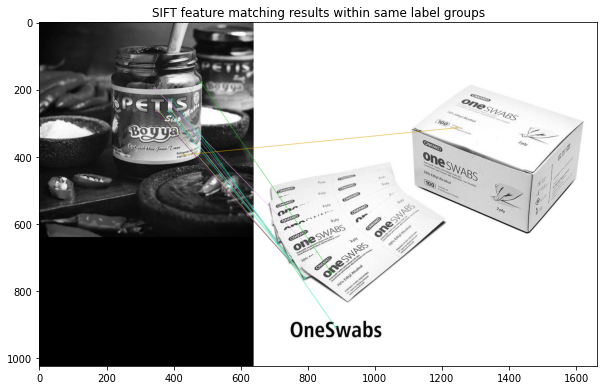

In [3]:
# Experiment Part ---------------------------------------------
# SIFT matching between query image and trained image

img1 = cv2.imread(sorted_train['image'].iloc[19], 0)          # queryImage
img2 = cv2.imread(sorted_train['image'].iloc[20], 0)          # trainImage


# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print('des1 shape :', des1.shape)
print('des2 shape :', des2.shape)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print('# of matched features :', len(good))

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print((img3).shape)
plt.figure(figsize=(10, 7))
plt.imshow(img3)
plt.title('SIFT feature matching results within same label groups')
plt.show()

des1 shape : (1451, 128)
des2 shape : (1471, 128)
# of matched features : 19
(1024, 1664, 3)


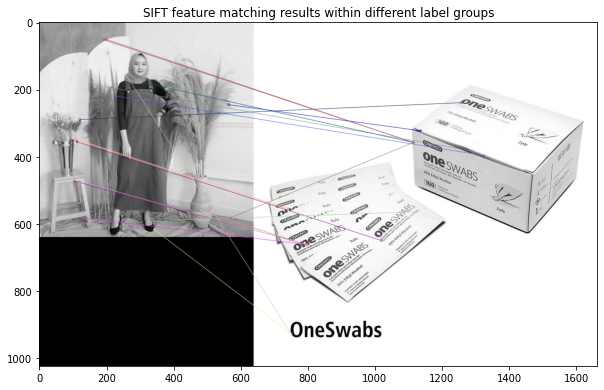

In [4]:
# SIFT matching between query image and trained image

img1 = cv2.imread(sorted_train['image'].iloc[3], 0)          # queryImage
img2 = cv2.imread(sorted_train['image'].iloc[20], 0)          # trainImage


# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print('des1 shape :', des1.shape)
print('des2 shape :', des2.shape)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print('# of matched features :', len(good))

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print((img3).shape)
plt.figure(figsize=(10, 7))
plt.imshow(img3)
plt.title('SIFT feature matching results within different label groups')
plt.show()

In [6]:
# Implementation Part ---------------------------------------------
import joblib
from sklearn import svm
import cv2

#n_samples = 300
n_labels = len(train['label_group'].value_counts()) # number of labels in train set
n_labels = 50

In [17]:
def calcSiftFeature(img):
    #Set image sift feature key points to a maximum of 200
    sift = cv2.SIFT_create(200)
    #sift = cv2.SURF_create()

    #Calculate the feature points and feature point description of the picture
    keypoints, features = sift.detectAndCompute(img, None)
    #temp = features[np.random.randint(features.shape[0], size=n_samples)]

    return features

In [8]:
#Calculation word bag
def learnVocabulary(features):
    wordCnt = n_labels # wordCnt is the number of categories  
    #criteria indicates the mode of iteration stop eps --- precision 0.1, max_iter --- meet more than the maximum number of iterations 20
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    #Get the initial center point of k-means clustering
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Label, center = kmeans(input data (feature), number of clusters K, preset label, cluster stop condition, number of repeated clusters, initial cluster center point
    compactness, labels, centers = cv2.kmeans(features, wordCnt, None, criteria, 20, flags)
    return centers

In [9]:
#Calculate feature vector
def calcFeatVec(features, centers):
    featVec = np.zeros((1, n_labels))
    for i in range(0, features.shape[0]):
        #The characteristic point of the i-th picture
        fi = features[i]
        diffMat = np.tile(fi, (n_labels, 1)) - centers
        #axis=1Sum by line, that is, the distance between the feature and each center point
        sqSum = (diffMat**2).sum(axis=1)
        dist = sqSum**0.5
        #Ascending order
        sortedIndices = dist.argsort()
        #Remove the smallest distance, that is, find the nearest center point
        idx = sortedIndices[0]
        #The center point corresponds to +1
        featVec[0][idx] += 1
    return featVec

In [10]:
# Build training set's word bag, After calculating the word bag, you need to save the word bag.
# You will need this word bag to find the feature vector of the picture in the subsequent test and 
# when predicting the new picture

def build_center():
    features = np.float32([]).reshape(0, 128)
    for idx in tqdm(range(0, N)):
        img = cv2.imread(train['image'].iloc[idx], 0)

        # Get sift feature points of image
        #kp, img_feat = sift.detectAndCompute(img, None)
        img_feat = calcSiftFeature(img)
        # pick 'n_samples' descriptors from each image
        #des_sample = img_feat[np.random.randint(img_feat.shape[0], size=n_samples)]
        features = np.append(features, img_feat, axis=0)

    print('features shape :', features.shape)
    #features = np.reshape(features, (N*n_samples,-1))
    # Training set of word bags
    centers = learnVocabulary(features)
    # Save the word bag
    filename = 'svm/svm_centers.npy'
    np.save(filename, centers)
    print('Word bag :', centers.shape)

In [11]:
# Find the feature vector of the picture through the word bag. In the experiment, path refers to the path,
# the training set path and the test set path. Enter the training set path to learn the picture feature
# vector and label, which is used to input the SVM classifier to train the model.
# Enter the set path, used to input the obtained image feature vector into the trained SVM classifier
# to obtain the prediction result, and compare it with the fact label to obtain the correct rate of the
# model on the test set.

def cal_vec():
    centers = np.load('svm/svm_centers.npy')
    data_vec = np.float32([]).reshape(0, n_labels)
    labels = np.float32([])
    for idx in range(0, N):
        img = cv2.imread(train['image'].iloc[idx], 0)
        img_f = calcSiftFeature(img) # shouldn't use features we already have?
        img_vec = calcFeatVec(img_f, centers)
        data_vec = np.append(data_vec, img_vec, axis = 0)
        #labels = np.append(labels, idx)
        labels = np.append(labels, train['label_group'].iloc[idx])
    print('data vec :', data_vec.shape)
    print('feature of the training set was calculated successfully')
    return data_vec, labels

In [12]:
# Train SVM classifier
def SVM_Train(data_vec, labels):
    # Set SVM model param
    #clf = svm.SVC(decision_function_shape='ovr')
    clf = svm.SVC(kernel='poly', degree=8)
    clf.fit(data_vec,labels)
    joblib.dump(clf, 'svm/svm_model.m')

In [13]:
# Test

def SVM_Test():
    clf = joblib.load('svm/svm_model.m')
    centers = np.load('svm/svm_centers.npy')
    
    data_vec, labels = cal_vec()
    res = clf.predict(data_vec)
    num_test = data_vec.shape[0]
    acc = 0
    #print('labels :',labels)
    #print('num_test :',num_test)
    #print('res :', res)
    # return 1, 2
    #return labels, res # debugging
    for i in range(num_test):
        if labels[i]  == res[i]:
            acc += 1

    return acc/num_test, res

In [18]:
build_center()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.99it/s]


features shape : (39737, 128)
Word bag : (50, 128)


In [19]:
data_vec, labels = cal_vec()

data vec : (200, 50)
feature of the training set was calculated successfully


In [20]:

SVM_Train(data_vec, train['label_group'])


In [21]:
acc, res = SVM_Test()

data vec : (200, 50)
feature of the training set was calculated successfully


In [22]:
train['predicted_label'] = res
train 

,posting_id,image,image_phash,title,label_group,target,predicted_label
0,train_129225211,../../../Documents/shopee-product-matching/tra...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,[train_129225211],249114794
1,train_3386243561,../../../Documents/shopee-product-matching/tra...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,[train_3386243561],2937985045
2,train_2288590299,../../../Documents/shopee-product-matching/tra...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,[train_2288590299],2395904891
3,train_2406599165,../../../Documents/shopee-product-matching/tra...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,[train_2406599165],4093212188
4,train_3369186413,../../../Documents/shopee-product-matching/tra...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,[train_3369186413],3648931069
...,...,...,...,...,...,...,...
195,train_2794195507,../../../Documents/shopee-product-matching/tra...,9c8c97b5c272596a,Jeans Anak 7/8 Wisker 141618/7-10 tahun,1999386573,[train_2794195507],3489985175
196,train_1192495588,../../../Documents/shopee-product-matching/tra...,fab185962ec43a69,NutriSari Markisa (10Sch) @14gr,2809031353,[train_1192495588],2809031353
197,train_3668574065,../../../Documents/shopee-product-matching/tra...,ba83858e4a38b56f,MamyPoko Perekat Royal Soft - L 62 - Popok Tape,2828399909,[train_3668574065],2828399909
198,train_3575321186,../../../Documents/shopee-product-matching/tra...,be13c2da5b1dca60,INFINIX HOT 9 Play 2/32 & 3/64 & 4/64 GARANSI...,1804381656,[train_3575321186],1804381656


In [24]:
acc

0.625

In [ ]:
train

In [ ]:
def predict(img):
    clf = joblib.load('svm/svm_model.m')
    centers = np.load('svm/svm_centers.npy')
    features = calcSiftFeature(img)
    featVec = calcFeatVec(features, centers)
    case = np.float32(featVec)
    res = clf.predict(case)
    return res

In [ ]:
given_img = cv2.imread('img/item.jpg', 0)
res = predict(given_img)
print(res)

In [ ]:
# 2021. 5. 24 at home
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd
import torch
from sklearn.metrics.pairwise import linear_kernel
import collections
from sklearn import svm
from scipy.spatial import distance
import joblib

N = 200
DATA_PATH = '../../../Documents/shopee-product-matching/'
#DATA_PATH = 'shopee-product-matching/'
train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
train = train.head(N)
text_data = train['title']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)
n_labels = len(train['label_group'].value_counts()) # number of labels in train set

In [ ]:

sift = cv2.SIFT_create()
total_sift_des = np.float32([]).reshape(0, 128)
n_sample = 20
for idx in tqdm(range(0, N)):
    img = cv2.imread(train['image'].iloc[idx], 0)
    kp, des = sift.detectAndCompute(img, None)
    des_sample = des[np.random.randint(des.shape[0], size=n_sample)]
    total_sift_des = np.append(total_sift_des, des_sample, axis = 0)


In [ ]:
#Calculation word bag
def learnVocabulary(features, n_labels):
    wordCnt = n_labels # wordCnt is the number of categories  
    #criteria indicates the mode of iteration stop eps --- precision 0.1, max_iter --- meet more than the maximum number of iterations 20
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    #Get the initial center point of k-means clustering
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Label, center = kmeans(input data (feature), number of clusters K, preset label, cluster stop condition, number of repeated clusters, initial cluster center point
    compactness, labels, centers = cv2.kmeans(features, wordCnt, None, criteria, 20, flags)
    return centers

In [ ]:
# Step 3, vocabulary constrction
vocab = learnVocabulary(total_sift_des, n_labels)

In [ ]:
# Save the vocabulary file
filename = 'svm/vocab.npy'
np.save(filename, vocab)
print('vocab shape :', vocab.shape)

In [ ]:
# Step 4, Classifying images using histograms (training/test data images)
sift = cv2.SIFT_create()

feats = np.int32([]).reshape(0, len(vocab))
for idx in tqdm(range(0, N)):
    img = cv2.imread(train['image'].iloc[idx], 0)
    kp, des = sift.detectAndCompute(img, None)
    dist = distance.cdist(des, vocab, 'euclidean')
    
    bin_assignment = np.argmin(dist, axis=1)
    
    image_feature = np.zeros(len(vocab))
    for id_assign in bin_assignment:
        image_feature[id_assign] += 1
        
    feats = np.vstack((feats, image_feature))



In [ ]:
# Normalizing and convert feats into np array
feats_normalized = np.linalg.norm(feats, axis=1)
for idx in range(0, feats.shape[0]):
    feats[idx] = feats[idx] / feats_normalized[idx]
    


In [ ]:
# Train SVM classifier
def SVM_Train(data_vec, labels):
    # Set SVM model param


In [ ]:
print(feats)
print(feats.shape)
gt_label = train['label_group']

clf = svm.SVC(kernel='poly', degree=8)
clf.fit(feats,gt_label)
joblib.dump(clf, 'svm/svm_model.m')

In [ ]:
y_pred = clf.predict(feats)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(gt_label, y_pred))
print(classification_report(gt_label, y_pred))